In [2]:
#imports
import os
import pandas as pd
import numpy as np
from srim import Ion, Target, Layer, TRIM
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as st

C:\Users\dziubins\Anaconda3\lib\site-packages\srim\core\elementdb.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(dbpath, "r"))


In [22]:
filen = input("File name:")

#--------------------BEAM PROPERTIES-----------------------#

b_element = 'Sn'
b_energy = 108*80*1e6
b_mass = 108

#---------------MATERIAL INPUT PARAMETERS------------------#

# Kevlar Window
kevlar_density = 1.44 #g/cm^3
window_thickness = 20 #mg/cm^2

# Xenon
P = 847 # Torr
V = 115 # Liters
T = 297 # Kelvin
R = 62.363 # L*Torr*K^-1*mol^-1
n = P*V/(R*T) # mol
molecular_weight = 131.29 # g/mol
#D = molecular_weight*n/(V*1000)
D = 0.005887 #g/cm3

#-------------------------BEAM-----------------------------#  

ion = Ion(b_element, b_energy, b_mass)

#------------------LAYER COMPOSITION-----------------------#

# Aluminum Beam Pipe Flange - 1 mm thick
    
Al = Layer({
    'Al': {
        'stoich': 1.0,
        'E_d': 25,
        'lattice': 3.0,
        'surface': 3.36
    }}, density=2.702, width=1e7)
    
# Air - 5 cm long

air = Layer({
    'Ar': {
        'stoich': 0.012827,
        'E_d': 5,
        'lattice': 1.0,
        'surface': 2},
    'N': {
        'stoich': 0.755267,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 2},
    'C': {
        'stoich': 0.000124,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 7.41},
    'O': {
        'stoich': 0.231781,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 2}
    }, density=1.2048e-3, width=5e8)
    
# Kevlar Reinforced Dyneema Window 

kevlar = Layer({
    'C': {                   # 70.58% Carbon
        'stoich': 0.7058,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 7.41},
    'N': {                   # 11.76% Nitrogen
        'stoich': 0.1176,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 2},
    'H': {                   # 4.23% Hydrogen
        'stoich': 0.0423,
        'E_d': 10,
        'lattice': 3.0,
        'surface': 2},
    'O': {                   # 13.43% Oxygen
        'stoich': 0.1343,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 2}
    }, density=1.4, width=window_thickness*1e-3*1e8/kevlar_density)
    
# Xe between Kevlar and 1st Electrode Foil
    
Xe0 = Layer({
    'Xe': {
        'stoich': 1.0,
        'E_d': 5,
        'lattice': 1.0,
        'surface': 2},
    }, density=D, width=10e8)
CF4 = Layer({
    'C': {
        'stoich': 1.0,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 7.41},
    'F': {
        'stoich': 4.0,
        'E_d': 25,
        'lattice': 3,
        'surface': 2}
    }, density=0.00372, width=10e8)
    
# Electrode Foil Aluminum Coating
Al_coat = Layer({
    'Al': {
        'stoich': 1.0,
        'E_d': 25,
        'lattice': 3.0,
        'surface': 3.36
    }}, density=2.702, width=1500)
polypropylene = Layer({
    'H': {
        'stoich': 6.0,
        'E_d': 10,
        'lattice': 3.0,
        'surface': 2},
    'C': {
        'stoich': 3.0,
        'E_d': 28,
        'lattice': 3.0,
        'surface': 7.41},
    }, density=0.93, width=0.4e4)

# Sector Xenon

Xe = Layer({
    'Xe': {
        'stoich': 1.0,
        'E_d': 5,
        'lattice': 1.0,
        'surface': 2},
    }, density=D, width=4.75e8)

#-----------------------TARGET-----------------------------#

#target = Target([Al,                                  # Aluminum ISO Flange
#                air,                                  # 5 cm Air Gap
#                kevlar,                               # Kevlar Window
#                Xe0,                                  # Entrance Xenon (not part of detection volume)
#                Al_coat, polypropylene, Al_coat])     # First Aluminized-Polypropylene Electrode Foil

target = Target([kevlar,                               # Kevlar Window
                 Xe0,                                  # Entrance Xenon (not part of detection volume)
                 Al_coat, polypropylene, Al_coat])     # First Aluminized-Polypropylene Electrode Foil

#target = Target([kevlar,                               # Kevlar Window
#                Xe0,                                   # Entrance Xenon (not part of detection volume)
#                Al_coat, polypropylene, Al_coat,
#                Xe,
#                Al_coat, polypropylene, Al_coat,
#                Xe,
#                Al_coat, polypropylene, Al_coat,
#                Xe,
#                Al_coat, polypropylene, Al_coat,
#                Xe])      # First Aluminized-Polypropylene Electrode Foil


#------------------TRIM RUN SETTINGS-----------------------#

calculation = 1
kwargs  = {"angle_ions":0, "ranges":True, "transmit":True}
srim_executable_directory = 'C://Users/dziubins/Desktop/SRIM'
SRIM_Outputs = 'C://Users/dziubins/Desktop/SRIM/SRIM Outputs/'

File name:108Sn_80MeV_WXF1


In [29]:
window_thickness*1e-3*1e8/kevlar_density/1e4


138.88888888888889

In [4]:
#----------------------FUNCTIONS---------------------------#
def make_transmit(trial, run):
    folder = 'E23508 Straggling Trial '+ trial + 'b/run' + str(run)
    os.chdir(SRIM_Outputs + folder)
    mainfolder_dir = os.getcwd()
    file = mainfolder_dir+'\\'+'TRANSMIT.txt'
    fo = open(file)
    strings = fo.readlines()
    
    #massage data to put into pandas
    lines = 12
    del strings[0:lines]
    for line in range(len(strings)):
        split_ion = strings[line].split()  
        s = set(split_ion) #make s a set of cut and pslit ions\
        if 'T' in s:
            split_ion.remove('T')
        if '-' in s:
            split_ion.remove('-')
        strings[line] = [float(p) for p in split_ion]

    #create pandas dataframe    
    a = ['Ion Num', 'Atomic Num', 'Energy(eV)', 'Depth X(A)', 'Lateral-Pos Y(A)', 
                     'Lateral-Pos Z(A)', 'Dir Cos(X)', 'Dir Cos(Y)', 'Dir Cos(Z)' ]
    df = pd.DataFrame(strings,columns=a)
    fo.close()
    
    return df

In [23]:
#----------------------TRIM RUN----------------------------#
trim = TRIM(target, ion, calculation, 1000,**kwargs)
results = trim.run(srim_executable_directory)

#-------------------SAVE SETTINGS--------------------------#

#folder = 'E23508 Trial '+ trial
file_directory = os.path.abspath(SRIM_Outputs + filen)
os.makedirs(file_directory, exist_ok=True)
TRIM.copy_output_files(srim_executable_directory, file_directory, check_srim_output= True)
    
    
    
#print("Window Thickness: ", window_thickness, "mg/cm^2")
#print("Volume: ", V, "L")
#print("Xenon Density: ", D, "g/cm^3")
print("Saved to ", file_directory)

Saved to  C:\Users\dziubins\Desktop\SRIM\SRIM Outputs\108Sn_80MeV_WXF1


In [37]:
#read in transmit file
#folder = 'E23508 Trial '+trial
os.chdir(SRIM_Outputs + filen)
mainfolder_dir = os.getcwd()
file = mainfolder_dir+'\\'+'TRANSMIT.txt'
fo = open(file)
strings = fo.readlines()

#massage data to put into pandas
lines = 12
del strings[0:lines]
for line in range(len(strings)):
    split_ion = strings[line].split()  
    s = set(split_ion) #make s a set of cut and pslit ions\
    if 'T' in s:
        split_ion.remove('T')
    if '-' in s:
        split_ion.remove('-')
    strings[line] = [float(p) for p in split_ion]

#create pandas dataframe    
a = ['Ion Num', 'Atomic Num', 'Energy(eV)', 'Depth X(A)', 'Lateral-Pos Y(A)', 
                 'Lateral-Pos Z(A)', 'Dir Cos(X)', 'Dir Cos(Y)', 'Dir Cos(Z)' ]
df = pd.DataFrame(strings,columns=a)
fo.close() 


print(b_element)
#average energy
originals = df['Energy(eV)']
avg_E = df['Energy(eV)'].mean()
print("Average Energy entering ELOSS:",avg_E/1e6,"MeV")
print("Percent Energy Loss before ELOSS:", round(( (b_energy - avg_E) / b_energy) * 100, 3), "%")
print("Energy Straggling (MeV)", (2.35*df['Energy(eV)'].std())/1e6)
print('--------------------------------')

Sn
Average Energy entering ELOSS: 7583.087448 MeV
Percent Energy Loss before ELOSS: 12.233 %
Energy Straggling (MeV) 9.653279975628752
--------------------------------


In [30]:
filen[:-4]+'Eff1'

'108Sn_80MeV_Eff1'

In [31]:
#filename = filen[:-4]+'Eff1_{0}'.format()
for i in range(len(df['Energy(eV)'])):
    
    #-------------------------BEAM-----------------------------#  

    ion = Ion('Sn', df.loc[i,'Energy(eV)'] , mass = 108)

    # add CF4
    CF4 = Layer({
        'C': {
            'stoich': 1.0,
            'E_d': 28,
            'lattice': 3.0,
            'surface': 7.41},
        'F': {
            'stoich': 4.0,
            'E_d': 25,
            'lattice': 3,
            'surface': 2}
        }, density=0.00372, width=4.75e8)


    #-----------------------TARGET-----------------------------#

    target = Target([Xe,                            # Sector 1 Xe
                     Al_coat,polypropylene,Al_coat, # ----------- 2nd Electrode Foil
                     Xe,                            # Sector 2 Xe
                     Al_coat,polypropylene,Al_coat, # ----------- 3rd Electrode Foil
                     Xe,                            # Sector 3 Xe
                     Al_coat,polypropylene,Al_coat, # ----------- 4th Electrode Foil
                     Xe])                           # Sector 4 Xe

    #------------------TRIM RUN SETTINGS-----------------------#

    calculation = 1
    kwargs  = {"angle_ions":0, "ranges":True, "transmit":True}
    trim = TRIM(target, ion, calculation, 2,**kwargs)
    srim_executable_directory = 'C://Users/dziubins/Desktop/SRIM'
    SRIM_Outputs = 'C://Users/dziubins/Desktop/SRIM/SRIM Outputs/'
    results = trim.run(srim_executable_directory)

    #-------------------SAVE SETTINGS--------------------------#

    #folder = 'E23508 EffV Trial '+ trial
    file_directory = os.path.abspath(SRIM_Outputs + filen[:-4]+'Eff1_{0}'.format(i))
    os.makedirs(file_directory, exist_ok=True)
    TRIM.copy_output_files(srim_executable_directory, file_directory, check_srim_output= True)

In [35]:
outgoing_E = []
for i in range(len(df['Energy(eV)'])):
    
    folder = SRIM_Outputs + filen[:-4] + 'Eff1_{0}'.format(i)
    T_file = folder + '\\' + 'TRANSMIT.txt'
    
    fo = open(T_file)
    strings = fo.readlines()

    lines = 12
    del strings[0:lines]
    for line in range(len(strings)):
        split_ion = strings[line].split()  
        s = set(split_ion) #make s a set of cut and pslit ions\
        if 'T' in s:
            split_ion.remove('T')
        if '-' in s:
            split_ion.remove('-')
        strings[line] = [float(p) for p in split_ion]

    #create pandas dataframe    
    a = ['Ion Num', 'Atomic Num', 'Energy(eV)', 'Depth X(A)', 'Lateral-Pos Y(A)', 
                    'Lateral-Pos Z(A)', 'Dir Cos(X)', 'Dir Cos(Y)', 'Dir Cos(Z)' ]
    df = pd.DataFrame(strings,columns=a)
    fo.close() 
    outgoing_E.append(df.loc[0,'Energy(eV)'])
    outgoing_E.append(df.loc[1,'Energy(eV)'])
    

In [41]:
8%2

0

In [47]:
eloss = []
c=0
original = originals[0]
for i in range(len(outgoing_E)):
    if i%2 == 0:
        #print(original,outgoing_E[i])
        eloss.append(original - outgoing_E[i])
    elif i%2 == 1:
        #print(original,outgoing_E[i])
        eloss.append(original - outgoing_E[i])
        c+=1
        if c < len(originals):
            original = originals[c]

In [57]:
np.std(eloss)/np.mean(eloss)*100


0.3476590904436229

In [8]:
#read in transmit file
folder = 'E23508 EffV Trial '+trial
os.chdir(SRIM_Outputs + folder)
mainfolder_dir = os.getcwd()
file = mainfolder_dir+'\\'+'TRANSMIT.txt'
fo = open(file)
strings = fo.readlines()

#massage data to put into pandas
lines = 12
del strings[0:lines]
for line in range(len(strings)):
    split_ion = strings[line].split()  
    s = set(split_ion) #make s a set of cut and pslit ions\
    if 'T' in s:
        split_ion.remove('T')
    if '-' in s:
        split_ion.remove('-')
    strings[line] = [float(p) for p in split_ion]

#create pandas dataframe    
a = ['Ion Num', 'Atomic Num', 'Energy(eV)', 'Depth X(A)', 'Lateral-Pos Y(A)', 
                 'Lateral-Pos Z(A)', 'Dir Cos(X)', 'Dir Cos(Y)', 'Dir Cos(Z)' ]
df = pd.DataFrame(strings,columns=a)
fo.close() 


print(b_element)
#average energy
avg_E2 = df['Energy(eV)'].mean()
print("Average Energy exiting ELOSS:",avg_E2/1e6,"MeV")
print("Energy Straggling* (MeV)", (2.35*df['Energy(eV)'].std())/1e6)
print("*Does not include straggling from entrance simulation")
print('--------------------------------')


Sn
Average Energy exiting ELOSS: 6129.483977 MeV
Energy Straggling* (MeV) 12.365001711728889
*Does not include straggling from entrance simulation
--------------------------------


In [37]:
print("Total Energy Loss in Effective Volume: ", (avg_E-avg_E2)/1e6)

Total Energy Loss in Effective Volume:  570.7641633333335


In [16]:
file = file_directory + "\\IONIZ.txt"
strings = open(file).readlines()
del strings[0:79]
for line in range(len(strings)):
    split_ion = strings[line].split()
    strings[line] = [float(p) for p in split_ion]
        


100


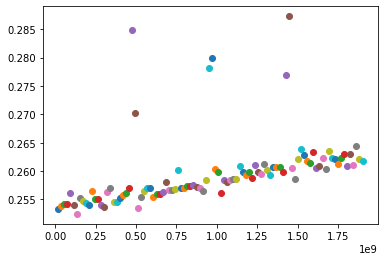

In [26]:
for i in range(len(strings)):
    plt.scatter(strings[i][0],strings[i][1])
print(len(strings))

In [26]:
#============Determination of total straggling=============#

trial = input("Trial#")

#--------------------BEAM PROPERTIES-----------------------#

b_element = 'Se'
#e_spread = np.random.normal(134, 134*0.001/2.35, 1000)
b_energy = np.array(energies)
#b_energy = 82*e_spread*1e6
b_mass = 82

print("Beam Energy: ", np.mean(b_energy)/1e6, "MeV and Beam Spread: ", np.std(b_energy)*2.35*100/np.mean(b_energy),"%")

#-----------------------TARGET-----------------------------#

#target = Target([Al,                                  # Aluminum ISO Flange
#                air,                                  # 5 cm Air Gap
#                kevlar,                               # Kevlar Window
#                Xe0,                                  # Entrance Xenon (not part of detection volume)
#                Al_coat, polypropylene, Al_coat])     # First Aluminized-Polypropylene Electrode Foil

target = Target([Xe,                            # Sector 1 Xe
                 Al_coat,polypropylene,Al_coat, # ----------- 2nd Electrode Foil
                 Xe,                            # Sector 2 Xe
                 Al_coat,polypropylene,Al_coat, # ----------- 3rd Electrode Foil
                 Xe,                            # Sector 3 Xe
                 Al_coat,polypropylene,Al_coat, # ----------- 4th Electrode Foil
                 Xe])                           # Sector 4 Xe

#-------------------------BEAM-----------------------------#  
for i in range(len(e_spread)):
    ion = Ion(b_element, b_energy[i] , mass = b_mass)

#----------------------TRIM RUN----------------------------#
    trim = TRIM(target, ion, calculation, 2,**kwargs)
    results = trim.run(srim_executable_directory)

#-------------------SAVE SETTINGS--------------------------#
    folder = 'E23508 Straggling Trial '+ trial + 'b/run' + str(i)
    file_directory = os.path.abspath(SRIM_Outputs + folder)
    os.makedirs(file_directory, exist_ok=True)
    TRIM.copy_output_files(srim_executable_directory, file_directory, check_srim_output= True)
    print("Run ",i)

Trial#1
Beam Energy:  9101.8220155 MeV and Beam Spread:  0.22215822662099863 %
Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19
Run  20
Run  21
Run  22
Run  23
Run  24
Run  25
Run  26
Run  27
Run  28
Run  29
Run  30
Run  31
Run  32
Run  33
Run  34
Run  35
Run  36
Run  37
Run  38
Run  39
Run  40
Run  41
Run  42
Run  43
Run  44
Run  45
Run  46
Run  47
Run  48
Run  49
Run  50
Run  51
Run  52
Run  53
Run  54
Run  55
Run  56
Run  57
Run  58
Run  59
Run  60
Run  61
Run  62
Run  63
Run  64
Run  65
Run  66
Run  67
Run  68
Run  69
Run  70
Run  71
Run  72
Run  73
Run  74
Run  75
Run  76
Run  77
Run  78
Run  79
Run  80
Run  81
Run  82
Run  83
Run  84
Run  85
Run  86
Run  87
Run  88
Run  89
Run  90
Run  91
Run  92
Run  93
Run  94
Run  95
Run  96
Run  97
Run  98
Run  99
Run  100
Run  101
Run  102
Run  103
Run  104
Run  105
Run  106
Run  107
Run  108
Run  109
Run  110
Run  111
Run  112
Run  113
Run  

Run  914
Run  915
Run  916
Run  917
Run  918
Run  919
Run  920
Run  921
Run  922
Run  923
Run  924
Run  925
Run  926
Run  927
Run  928
Run  929
Run  930
Run  931
Run  932
Run  933
Run  934
Run  935
Run  936
Run  937
Run  938
Run  939
Run  940
Run  941
Run  942
Run  943
Run  944
Run  945
Run  946
Run  947
Run  948
Run  949
Run  950
Run  951
Run  952
Run  953
Run  954
Run  955
Run  956
Run  957
Run  958
Run  959
Run  960
Run  961
Run  962
Run  963
Run  964
Run  965
Run  966
Run  967
Run  968
Run  969
Run  970
Run  971
Run  972
Run  973
Run  974
Run  975
Run  976
Run  977
Run  978
Run  979
Run  980
Run  981
Run  982
Run  983
Run  984
Run  985
Run  986
Run  987
Run  988
Run  989
Run  990
Run  991
Run  992
Run  993
Run  994
Run  995
Run  996
Run  997
Run  998
Run  999


In [23]:
energies = []
for i in range(len(b_energy)):
    energies.append(make_transmit('1', i)['Energy(eV)'][0])
    energies.append(make_transmit('1', i)['Energy(eV)'][1])
    
print(energies)

[9090928000.0, 9106259000.0, 9113139000.0, 9110236000.0, 9110230000.0, 9097874000.0, 9094933000.0, 9104474000.0, 9107119000.0, 9106684000.0, 9100270000.0, 9102678000.0, 9095279000.0, 9103608000.0, 9103133000.0, 9100952000.0, 9093458000.0, 9099938000.0, 9115263000.0, 9111756000.0, 9106524000.0, 9112958000.0, 9098140000.0, 9113374000.0, 9085273000.0, 9099670000.0, 9090720000.0, 9090558000.0, 9107014000.0, 9100778000.0, 9111234000.0, 9114110000.0, 9094162000.0, 9092441000.0, 9110610000.0, 9117098000.0, 9109042000.0, 9115336000.0, 9100767000.0, 9098818000.0, 9089587000.0, 9106689000.0, 9100963000.0, 9099130000.0, 9108049000.0, 9103178000.0, 9104410000.0, 9107020000.0, 9079704000.0, 9105348000.0, 9112217000.0, 9107610000.0, 9094541000.0, 9089399000.0, 9104509000.0, 9100913000.0, 9112916000.0, 9089506000.0, 9099199000.0, 9097875000.0, 9107845000.0, 9109551000.0, 9108622000.0, 9091285000.0, 9091923000.0, 9082044000.0, 9103500000.0, 9111816000.0, 9100297000.0, 9101662000.0, 9110695000.0, 91011

In [39]:
#energies = []
#for i in range(1000):
#    energies.append(make_transmit('1', i)['Energy(eV)'][0])
#    energies.append(make_transmit('1', i)['Energy(eV)'][1])
    
print("Avg. Energy: ",st.mean(energies)/1e6, "MeV")
print("Energy Standard Deviation: ", st.stdev(energies)/1e6, "MeV")
print("Straggling Sigma: ", st.stdev(energies)/st.mean(energies)*100)

Avg. Energy:  8603.0427305 MeV
Energy Standard Deviation:  9.69504038232318 MeV
Straggling Sigma:  0.1126931562010237


In [4]:
print(D)

0.006003874567125212
